# Recurrent Neural Networks #

When we studied word2vec, we used sequential data to make a network learn relationships between an input and its sorrounding context. 

The next logical step would be to make a network learn not just the context, but perhaps an long with $T$ elements. This is what Recurrent Neural Networks (RNNs) do.

The general expression describing the forward pass of a simple RNN is:

$$\hat{y}_t = softmax\big(~h_t~W^{(o)}\big)$$

where $t$ indicates the time-step we are currently evaluating, and where $h$ represents the hidden state at time $t$ given by:

$$h = f(~x_t~W^{(i)} ~+~h_{t-1}W^{(h)})$$

where $f()$ is an arbitrary non-linear function.

Observing the math for the forward pass, you can see that an RNN is very similar to the feedforward neural networks we have been studying so far. 

However, one major difference is:

* a new $W^{(h)}$ that we use to pass information about the hidden state at time-step to the current time-step. 

What dimension does $W^{(h)}$ have to be?

Another difference is the cost function that we need to use:

$$J = \sum_t -\log(\hat{y}_{t~correct})$$

In [21]:
# vocabulary size
V = 21

word_to_i = Dict("I" => 0, "got" => 1, "idea" => 2, "man" => 3, "You" => 4, "take" => 5, "me" => 6, "for" => 7, "a" => 8, "walk" => 9, "Under" => 10, "the" => 11, "sycamore" => 12, "trees" => 13, "dark" => 14, "that" => 15, "blow" => 16, "baby" => 17, "In" => 18, "<end>" => 19, "<start>" => 20)

i_to_word = Dict( 0 => "I", 1=> "got", 2 => "idea", 3 => "man", 4 => "You", 5=> "take", 6 => "me", 7 => "for", 8=> "a", 9 => "walk", 10 => "Under", 11 => "the", 12 => "sycamore", 13 =>"trees", 14=> "dark", 15 => "that", 16 => "blow", 17 => "baby",18 =>"In", 19 => "<end>", 20 => "<start>")

verse = [20,0,1,2,3,4,5,6,7,8,9,10,11,12,13,11,14,13,15,16,17,18,11,14,13,15,16,19];

# let's see the verse
for i = 1:size(verse)[1]
    print(i_to_word[verse[i]], " ")
end

# correct for the base one indexing
verse = verse + 1 

# now generate the x matrix
x = zeros(size(verse)[1], V)
for i=1:size(verse)[1]
   x[i,verse[i]] = 1
end

# now generate the y vector
y = verse;

<start> I got idea man You take me for a walk Under the sycamore trees the dark trees that blow baby In the dark trees that blow <end> 

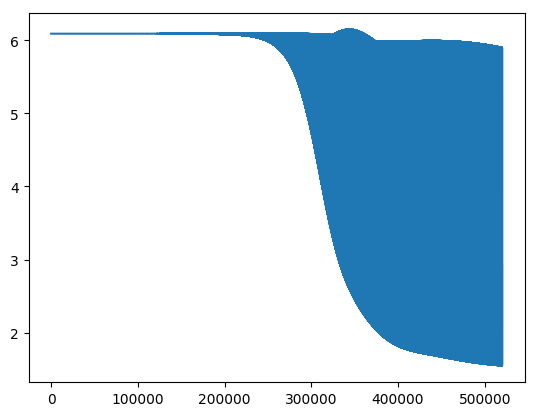

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7ff0dcfe1450>

In [22]:
x_tr = x
y_tr = y
D = V
C = V

# hyperparameter alpha
a = 0.0002
# the number of hidden layers
H = 2

# the W matrix
W_h = (rand(D,H)*0.001);
W_o = (rand(H,C)*0.001);
nepochs = 20000
J = zeros(nepochs*(size(x_tr)[1]-2),1)
J_i = 1
for ep=0:nepochs-1

    for t=2:size(x_tr)[1]-1

        # forward pass (without non-linearity into the hidden layer)
        h = *(reshape(x_tr[t,:],1,D),W_h)
        scores = *(reshape(h,1,H),W_o)
        probs = exp(scores)./sum(exp(scores))

        # objective 
        J[floor(Int,J_i),1] = -log(probs[1,floor(Int,y_tr[t-1])]*probs[1,floor(Int,y_tr[t+1])])
        J_i +=1
        
        # backward pass
        dJ_dscores = 2*probs # times two, because we are looking a word before and a word after 
        dJ_dscores[1,floor(Int,y_tr[t-1])] -= 1
        dJ_dscores[1,floor(Int,y_tr[t+1])] -= 1                
        
        # (without non-linearity back to the hidden layer)
        dJ_dW_o = *(h',dJ_dscores)        
        dJ_dW_h = *(reshape(x_tr[t,:],1,D)',(*(dJ_dscores,W_o')))

        W_h -= a*dJ_dW_h;
        W_o -= a*dJ_dW_o;        

    end
end
using PyPlot
plot(J)

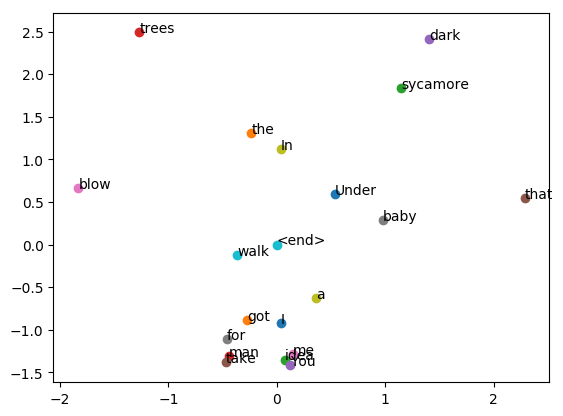

In [23]:
# this should generate a plot of your word_embeddings

using PyPlot

for i=1:V-1
    scatter(W_h[i,1], W_h[i,2])
    annotate(i_to_word[i-1],(W_h[i,1], W_h[i,2]))
end

In [24]:
# now we redefine the x data matrix with the embeddings
W_embeddings = W_h
D = 2
N = size(verse)[1]

x = zeros(N,2)
for i=1:N
   
    x[i,:] = W_embeddings[verse[i],:]
    
end

# the y vector can stay the same

The data hence looks as follows:

* an x matrix (containing the datapoints) of size [N x D]
* a y vector containing the "one-hot" index of the correct label for each row in x

In the next cell, initialize your $W^{(i)}$, $W^{(h)}$, $W^{(o)}$ matrices with random numbers, and carry out the forward pass of the RNN for the entire verse (stop once you have a loss calculated). 

The goal is to correctly classify the input word at each time-step.

You will also have to initialize the $h$ state before the network gets any inputs. It is common practice to initialize this hidden state using zeros

In [49]:
# [your code here:]
H = 10

3.4822581402664587

Believe it or not, this is already a generative model (perhaps a really crappy one). The following cell should be able to use your neurons in $W^{(i)}$, $W^{(h)}$, $W^{(o)}$ and generate new text after we initialize the network with the words: "The dark trees"

In [64]:
tickle_indices = [word_to_i["I"],word_to_i["got"]] + 1
# using the word embeddings
tickles = zeros(size(tickle_indices)[1],D)
for i=1:size(tickle_indices)[1]
    
    tickles[i,:] = W_embeddings[floor(Int,tickle_indices[i]),:]
    
end

# desired total length of sentence generated:
S_length = 10

# initialize hidden state
h_prev = zeros(1,size(W_h)[1])

# this loop tickles the RNN
sentence = zeros(S_length, 1)
for t = 1:size(tickle_indices)[1]
    
    h_now = tanh(reshape(tickles[t,:],1,D) * W_i + h_prev * W_h)
    scores = h_now * W_o
    y_hat = exp(scores)./sum(exp(scores))
    mxval, mxindx = findmax(y_hat)
    sentence[t,1] = mxindx
    
    h_prev = h_now
end

# this loop keeps the RNN going even after the tickles have ended
for t = size(tickles)[1]:S_length
    
    h_now = tanh(h_prev * W_h)
    scores = h_now * W_o
    y_hat = exp(scores)./sum(exp(scores))
    mxval, mxindx = findmax(y_hat)
    sentence[t,1] = mxindx
    
    h_prev = h_now
end

# this loops turns the indices stored in the "sentence" array into human-readable words
for t=1:S_length

    print(i_to_word[sentence[t]-1])
    print(' ')
    
end

man blow blow blow blow blow blow blow blow blow 

As you can tell, the model is really bad. In order to improve it we will need to backpropragate the error associated with the cost function w.r.t learnable parameters:

$$J = \sum_t J_t = \sum_t -\log(\hat{y}_{t~correct})$$

$$\frac{\partial J}{\partial W^{(i)}}$$

$$\frac{\partial J}{\partial W^{(h)}}$$

$$\frac{\partial J}{\partial W^{(o)}}$$

Let's start with $\frac{\partial J}{\partial W^{(o)}}$. For this example, assume $T = 3$. Hence we have:

$\frac{\partial J}{\partial W^{(o)}} = \sum_t^3 \frac{\partial J_t}{\partial W^{(o)}}$

$\frac{\partial J}{\partial W^{(o)}} = \sum_t^3 ~\big(\frac{\partial f(~x_t~W^{(i)} + ~h_{t-1}~W^{(h)})~W^{(o)}}{\partial W^{(o)}}\big)^T~\frac{\partial J_t}{\partial \hat{y}} ~\frac{\partial \hat{y}}{\partial f(~x_t~W^{(i)} + ~h_{t-1}~W^{(h)}) ~W^{(o)}} = \sum_t^3 ~f(~x_t~W^{(i)} + ~h_{t-1}~W^{(h)})^T~\frac{\partial J_t}{\partial s}$

In [25]:
# your code here:

2.884558391813008


In [26]:
tickle_indices = [word_to_i["I"],word_to_i["trees"]] + 1 # one corrects for the zero-base indexing
# using the word embeddings
tickles = zeros(size(tickle_indices)[1],D)
for i=1:size(tickle_indices)[1]
    
    tickles[i,:] = W_embeddings[floor(Int,tickle_indices[i]),:]
    
end

# desired total length of sentence generated:
S_length = 10

# initialize hidden state
h_prev = zeros(1,size(W_h)[1])

# this loop tickles the RNN
sentence = zeros(S_length, 1)
for t = 1:size(tickle_indices)[1]
    
    h_now = tanh(reshape(tickles[t,:],1,D) * W_i + h_prev * W_h)
    scores = h_now * W_o
    y_hat = exp(scores)./sum(exp(scores))
    mxval, mxindx = findmax(y_hat)
    sentence[t,1] = mxindx
    
    h_prev = h_now
end

# this loop keeps the RNN going even after the tickles have ended
for t = size(tickles)[1]:S_length
    
    h_now = tanh(h_prev * W_h)
    scores = h_now * W_o
    y_hat = exp(scores)./sum(exp(scores))
    mxval, mxindx = findmax(y_hat)
    sentence[t,1] = mxindx
    
    h_prev = h_now
end

# this loops turns the indices stored in the "sentence" array into human-readable words
for t=1:S_length

    print(i_to_word[sentence[t]-1])
    print(' ')
    
end

You You trees You trees You trees You trees You 

To make this even better we will have to backpropagate $\frac{\partial J}{\partial W^{(h)}}$ and $\frac{\partial J}{\partial W^{(i)}}$ too (remember that in this example $T = 3$):

$\frac{\partial J}{\partial W^{(h)}} = \sum_t^3 ~\big(\frac{\partial f(~x_t~W^{(i)} + ~h_{t-1}~W^{(h)})~W^{(o)}}{\partial W^{(h)}}\big)^T~\frac{\partial J_t}{\partial f(~x_t~W^{(i)} + ~h_{t-1}~W^{(h)}) ~W^{(o)}}$

$\sum_t^3 ~\big(\frac{\partial f(~x_t~W^{(i)} + ~h_{t-1}~W^{(h)})~W^{(o)}}{\partial f(~x_t~W^{(i)} + ~h_{t-1}~W^{(h)})}~\frac{\partial f(~x_t~W^{(i)} + ~h_{t-1}~W^{(h)})}{\partial W^{(h)}}\big)^T~\frac{\partial J_t}{\partial f(~x_t~W^{(i)} + ~h_{t-1}~W^{(h)}) ~W^{(o)}}$
$\sum_t^3 ~\big(\frac{\partial f(~x_t~W^{(i)} + ~h_{t-1}~W^{(h)})~W^{(o)}}{\partial f(~x_t~W^{(i)} + ~h_{t-1}~W^{(h)})}~\frac{\partial f(~x_t~W^{(i)} + ~h_{t-1}~W^{(h)})}{\partial ~x_t~W^{(i)} + ~h_{t-1}~W^{(h)}}\frac{\partial ~x_t~W^{(i)} + ~h_{t-1}~W^{(h)}}{\partial W^{(h)}}\big)^T~\frac{\partial J_t}{\partial f(~x_t~W^{(i)} + ~h_{t-1}~W^{(h)}) ~W^{(o)}}$

In [74]:
# [your code here:]

0.22505941640715427


In [75]:
tickle_indices = [word_to_i["I"],word_to_i["trees"]] + 1 # one corrects for the zero-base indexing
# using the word embeddings
tickles = zeros(size(tickle_indices)[1],D)
for i=1:size(tickle_indices)[1]
    
    tickles[i,:] = W_embeddings[floor(Int,tickle_indices[i]),:]
    
end

# desired total length of sentence generated:
S_length = 10

# initialize hidden state
h_prev = zeros(1,size(W_h)[1])

# this loop tickles the RNN
sentence = zeros(S_length, 1)
for t = 1:size(tickle_indices)[1]
    
    h_now = tanh(reshape(tickles[t,:],1,D) * W_i + h_prev * W_h)
    scores = h_now * W_o
    y_hat = exp(scores)./sum(exp(scores))
    mxval, mxindx = findmax(y_hat)
    sentence[t,1] = mxindx
    
    h_prev = h_now
end

# this loop keeps the RNN going even after the tickles have ended
for t = size(tickles)[1]:S_length
    
    h_now = tanh(h_prev * W_h)
    scores = h_now * W_o
    y_hat = exp(scores)./sum(exp(scores))
    mxval, mxindx = findmax(y_hat)
    sentence[t,1] = mxindx
    
    h_prev = h_now
end

# this loops turns the indices stored in the "sentence" array into human-readable words
for t=1:S_length

    print(i_to_word[sentence[t]-1])
    print(' ')
    
end

got You <start> the got idea man You <start> walk 